<a href="https://colab.research.google.com/github/AlejandroSepulvedaGuatecique/Pandas_Exercise/blob/main/Back_PWP_analysis_set_9_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Example using constrained GP model
This is the code used to produce the first example in the paper _'Gaussian processes with linear operator inequality constraints'_, https://arxiv.org/abs/1901.03134

In [4]:
!git clone https://github.com/cagrell/gp_plotly
!git clone https://github.com/cagrell/gp_constr
!pip install chart_studio
!pip install pyDOE

fatal: destination path 'gp_plotly' already exists and is not an empty directory.
fatal: destination path 'gp_constr' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Load R
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [6]:
# indicate that you're running R code
%%R

# Install if it's your first time to run
install.packages("tmvtnorm") 
install.packages("TruncatedNormal")
install.packages("truncnorm")




(as ‘lib’ is unspecified)







	‘/tmp/RtmpqY25cR/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpqY25cR/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpqY25cR/downloaded_packages’



### Imports

In [7]:
### Basic imports ###
import sys, os

# For plotting
from IPython.display import display, HTML

# This is for plotting as static images (to show on e.g. GitHub)
import plotly.io as pio
from IPython.display import Image

# Numerics
import numpy as np
import scipy as sp
import itertools
import pyDOE

### Custom files ###

dir_GPPlotly = '/content/gp_plotly'
sys.path.append(dir_GPPlotly) 

# Path to the constrained GP moule 
# can be downloaded at https://github.com/cagrell/gp_constr
dir_gp_constr = '/content/gp_constr'
sys.path.append(dir_gp_constr) 

# Import
from GPPlotly.plottingfunctions import PlotGP2d, add_traces_to_fig
from GPConstr.model import GPmodel, Constraint
from GPConstr.kern import kernel_RBF

### Setup notebook ###
print('Python version', sys.version)

Loading constrained GP module from /content
Loading R wrapper...





Attaching package: ‘TruncatedNormal’



    dtmvnorm, dtmvt, ptmvnorm, ptmvt, rtmvnorm, rtmvt



    pmvnorm, pmvt




Running R from rpy2: R version 4.2.1 (2022-06-23)
Python version 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]


In [8]:
os.getcwd()
os.chdir('/content')

In [9]:
from matplotlib.colors import LinearSegmentedColormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)  

## 1. PROCESSING DATA SET


In [16]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df_d = pd.read_excel('BACK_TABLE_PYTHON.xlsx') 
df_d.head()

y = df_d[['ru_end']]
X = df_d[['Qcr', 'AI','H']]
m = len(y)
n = np.size(X,1)
y = np.hstack((np.ones((m,1)),y))
X = np.hstack((np.ones((m,1)),X))
X = np.delete(X,[0],axis=1)
y = np.delete(y,[0],axis=1)
y = y.flatten()


Qcrmax = np.max(X[:,0])
Qcrmin = np.min(X[:,0])
X[:,0] = (X[:,0]-Qcrmin)/(Qcrmax-Qcrmin)
AImax = np.max(X[:,1])
AImin = np.min(X[:,1])
X[:,1] = (X[:,1]-AImin)/(AImax-AImin)
Hmax = np.max(X[:,2])
Hmin = np.min(X[:,2])
X[:,2] = (X[:,2]-Hmin)/(Hmax-Hmin)

Qcrmax_norm = np.max(X[:,0])
Qcrmin_norm = np.min(X[:,0])


AImax_norm = np.max(X[:,1])
AImin_norm = np.min(X[:,1])

Hmax_norm = np.max(X[:,2])
Hmin_norm = np.min(X[:,2])
n_plot = 20
Qcr_plot = np.linspace(Qcrmin_norm, Qcrmax_norm, n_plot)
AI_plot = np.linspace(AImin_norm, AImax_norm, n_plot)
H_plot = np.linspace(Hmin_norm, Hmax_norm, n_plot)

X_train = X
y_train = y

## 2. Regression with Gaussian noise

### 2.2. Define GP model (without constraints)

In [612]:
# Set up model

ker = kernel_RBF(variance = 0.25, lengthscale = [0.4, 1.5, 0.2])
model = GPmodel(kernel = ker, likelihood = 0.2, mean = 0) 

# Add the training data
model.X_training = X_train

model.Y_training = y_train
print(model)

----- GP model ----- 
 mean = 0 
 likelihood = 0.2 
 kernel: 
   type = RBF 
   input dim = 3 
   lenghtscale = [0.4 1.5 0.2] 
   variance = 0.25 
 constraint: 
   No constraints 
---------------------


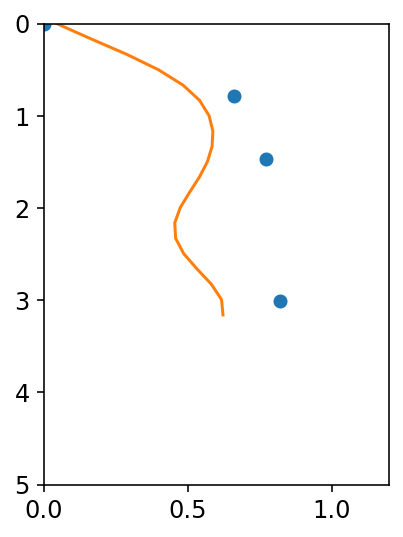

In [613]:
df1 = (df_d['Qcr']-Qcrmin)/(Qcrmax-Qcrmin)
df2 = (df_d['AI']-AImin)/(AImax-AImin)
df3 = (df_d['H']-Hmin)/(Hmax-Hmin)
df4 = df_d['ru_end']
df0 = df_d['Label']
DF = pd.concat([df0,df1,df2,df3,df4], axis=1, join='inner')

bol = DF['Label'] == "RPI12"
RPI10 = DF[bol]
print(RPI10['Qcr'].iat[0])

X, Y = np.meshgrid(AI_plot, H_plot)
Dr_exp = RPI10['Qcr'].iat[0]*(np.ones((n_plot,1)))
AI_exp = RPI10['AI'].iat[0]*(np.ones((n_plot,1)))

xy = np.column_stack((Dr_exp,AI_exp,H_plot))
Z_mean, Z_var = model.calc_posterior_unconstrained(xy, full_cov = True)
Z_std = np.diagonal(Z_var)


fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.4,0.8])
axes.plot(RPI10['ru_end'],RPI10['H']*(Hmax-Hmin)+Hmin,'o')
axes.plot(Z_mean,H_plot*(Hmax-Hmin)+Hmin)
plt.ylim(5, 0)
plt.xlim(0, 1.2)
clear_output(wait=True)

In [269]:
# Optimize hyperparameters
model.optimize(include_constraint = False, fix_likelihood = False)
print(model)

..Running optimization for unconstrained GP ... DONE - Total time: 0.194 seconds
----- GP model ----- 
 mean = 0 
 likelihood = 0.023402488241675734 
 kernel: 
   type = RBF 
   input dim = 3 
   lenghtscale = [0.72631944 2.28594209 0.10807078] 
   variance = 0.2772153013640186 
 constraint: 
   No constraints 
---------------------


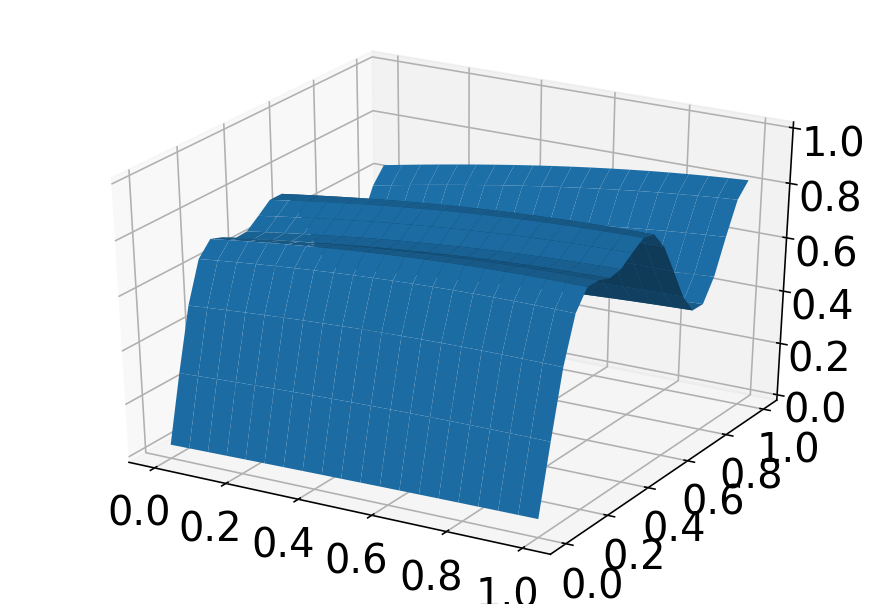

In [380]:
#@title
X, Y = np.meshgrid(AI_plot, H_plot)
Dr65 = 0.5*(np.ones((n_plot,1)))
xy = np.column_stack((Dr65,X[:,0],Y[:,0]))
Z_mean, Z_var = model.calc_posterior_unconstrained(xy, full_cov = True)
Z_std = np.diagonal(Z_var)
for i in range(1,X.shape[1]):
      print(i)
      xy = np.column_stack((Dr65,X[:,i],Y[:,i]))
      z_mean, z_var = model.calc_posterior_unconstrained(xy, full_cov = True)
      z_std = np.diagonal(Z_var)
      Z_mean = np.column_stack((Z_mean,z_mean))
      Z_std = np.column_stack((Z_std,z_std))



fig = plt.figure()
ax = Axes3D(fig)

surf = ax.plot_surface(X,Y,Z_mean)
clear_output(wait=True)

ax.set_zlim([0,1])
plt.show()



In [271]:
#@title
X, Y = np.meshgrid(Qcr_plot, H_plot)
AI = 1*(np.ones((n_plot,1)))
xy = np.column_stack((Dr65,X[:,0],Y[:,0]))
Z_mean, Z_var = model.calc_posterior_unconstrained(xy, full_cov = True)
Z_std = np.diagonal(Z_var)
for i in range(1,X.shape[1]):
      print(i)
      clear_output(wait=True)
      xy = np.column_stack((X[:,i],Dr65,Y[:,i]))
      z_mean, z_var = model.calc_posterior_unconstrained(xy, full_cov = True)
      z_std = np.diagonal(Z_var)
      Z_mean = np.column_stack((Z_mean,z_mean))
      Z_std = np.column_stack((Z_std,z_std))
      clear_output(wait=True)

clear_output(wait=True)




..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Calculating f* | Y ... DONE - Total time: 0.002 seconds


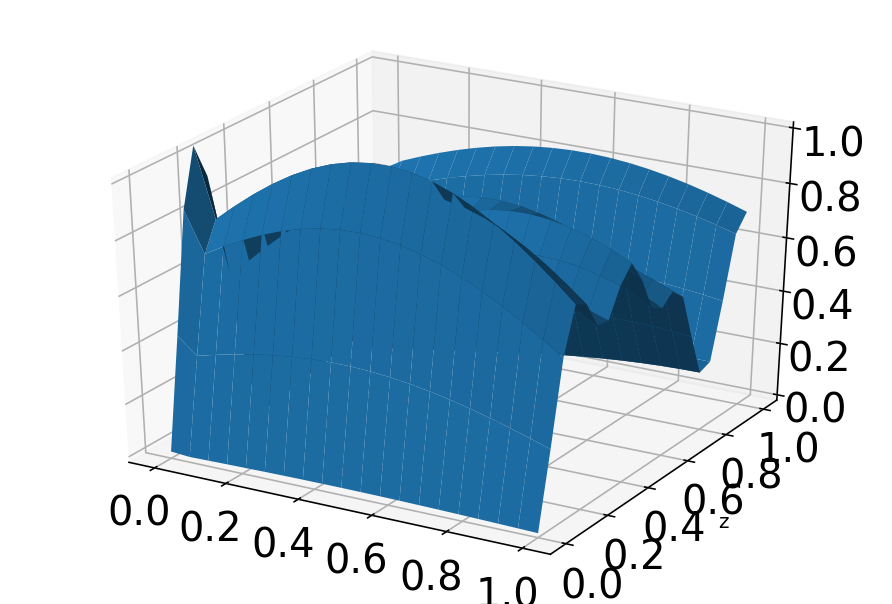

In [272]:
#@title
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)

surf = ax.plot_surface(X,Y,Z_mean)
ax.set_zlim([0,1])
plt.ylabel('z')
plt.show()

### 2.2.3. Include constraints (boundedness and monotonicity)

In [614]:
# Helper functions for constraints
def constant_function(val):
    """ Return the constant function"""
    def fun(x):
        return np.array([val]*x.shape[0])
    
    return fun

def fun_UB(x):
    """ Upper bound function """
    #return (np.exp(x[:,2].flatten())-1) + 0.1
    return  np.tanh(100*x[:,2].flatten())
def fun_LB(x):
    """ Upper bound function """
    #return -1*(np.exp(x[:,2].flatten())-1) - 0.1
    return  -1*np.tanh(100*x[:,2].flatten())


In [615]:
# Define constraints for bounding the function and its derivative
constr_bounded = Constraint(LB = fun_LB, UB = fun_UB)
#constr_deriv = Constraint(LB = constant_function(0), UB = constant_function(float('Inf')))

In [616]:
# Add constraints to model
model.constr_bounded = constr_bounded
#model.constr_deriv = [constr_deriv] # Add list of constraints for multi-dimensional functions
model.constr_likelihood = 0.1

print(model)


----- GP model ----- 
 mean = 0 
 likelihood = 0.2 
 kernel: 
   type = RBF 
   input dim = 3 
   lenghtscale = [0.4 1.5 0.2] 
   variance = 0.25 
 constraint: 
   f [0] 
   constr_likelihood = 0.1 
---------------------


In [617]:
Omega = np.random.uniform(size = (1000, 3))
df, num_pts, pc_min = model.find_XV_subop(p_target = 0.9, Omega = Omega, sampling_alg = 'minimax_tilting', num_samples = 10,
                         max_iterations = 1, print_intermediate = False)

# Then we run multiple iterations with p_target = 0.7 
Omega = np.random.uniform(size = (1000, 3)) # Candidate set
df, num_pts, pc_min = model.find_XV_subop(p_target = 0.9, Omega = Omega, sampling_alg = 'minimax_tilting', num_samples = 10,
                         max_iterations = 50, print_intermediate = False)

model.constrprob_Xv(n = 1000)


Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.9 for Lf = [f] and nu = 0.12815515655446005 ...
DONE - Found 1 points. Min. constraint prob = 0.5758876130316645. Total time spent = 0.045 seconds
Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.9 for Lf = [f] and nu = 0.12815515655446005 ...
DONE - Found 7 points. Min. constraint prob = 0.9004837501302589. Total time spent = 0.136 seconds


5.1034832381875546e-08

## OUTLIER ANALYSIS

In [618]:
Z_mean, Z_var, perc, mode, samples, sampling_time  = \
model.calc_posterior_constrained(X_train, compute_mode = False, num_samples = 1000, \
save_samples = 1, algorithm = 'minimax_tilting', resample = False)

mean = np.zeros((len(Z_mean)))
mean[:]= Z_mean.flatten()


..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.003 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.001 seconds
..sampling 1000 times from truncated constraint distribution C~|C, Y DONE - time: 0.016 seconds
..sampling 1000 times from constrained GP f*|C, Y DONE - time: 0.006 seconds
..computing statistics from samples DONE - time: 0.003 seconds
 DONE - Total time: 0.032 seconds


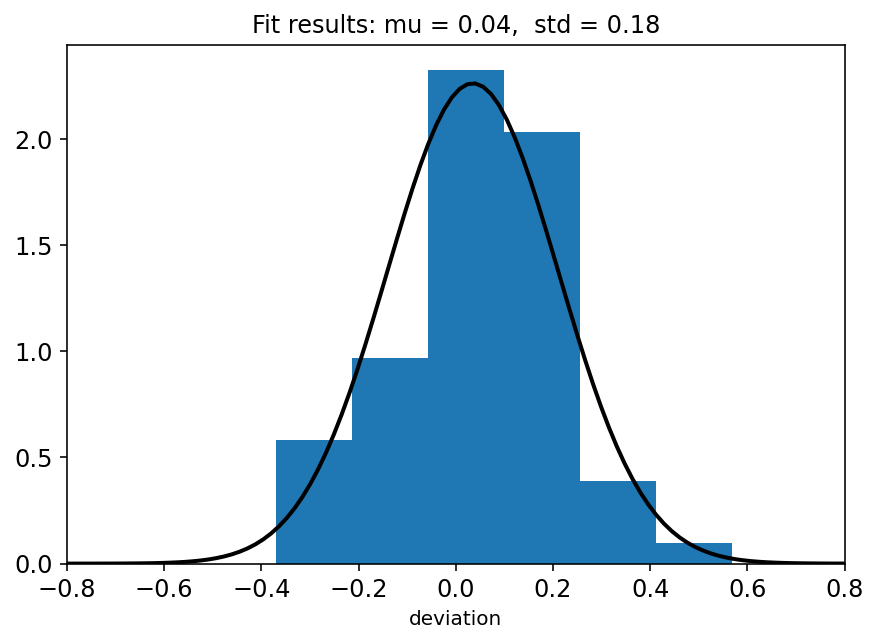

In [619]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
# Fit a normal distribution to the data:
dev = y_train - mean
mu, std = norm.fit(dev)
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.9,0.9])
# Plot the histogram.
plt.hist(dev, bins=6, density=True, alpha=1)
# Plot the PDF.
axes.set_xlabel('deviation')
axes.set_xlim([-0.8,0.8])
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

(-6.0, 6.0)

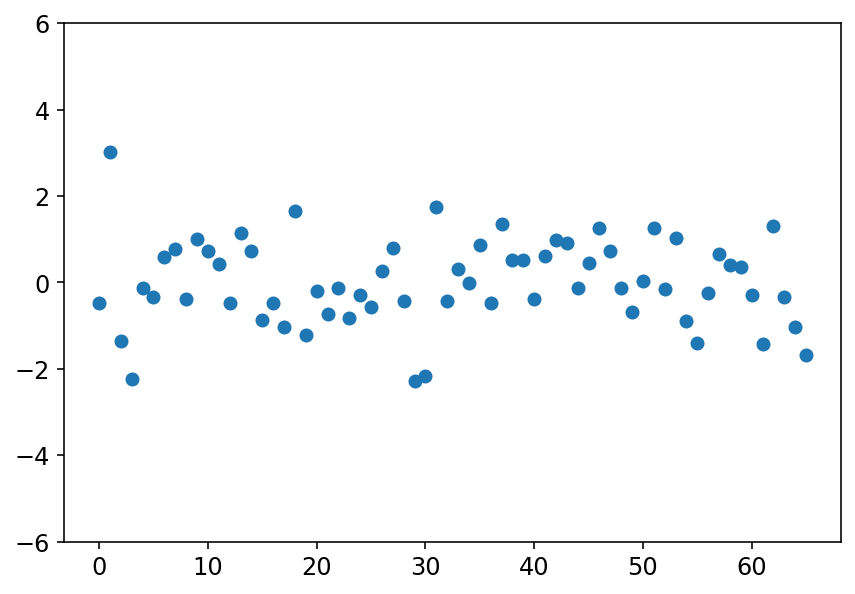

In [620]:
zscore=2;
zscoredata=(dev-mu)/std

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.9,0.9])
# Plot the histogram.
axes.plot(zscoredata,'o')
axes.set_ylim([-6,6])

In [621]:
bol= np.absolute(zscoredata)<=2
print(df_d.iloc[np.logical_not(bol),:])
X_train_z = X_train[bol,:]
y_train_z = y_train[bol]
DF['marker'] = DF['ru_end']
for i in range(0,len(bol),1):
  if bol[i] == True:  
      DF['marker'][i] = 'o'
  else:
      DF['marker'][i] = 'x'


   Label    ru_end        Qcr    AI      H
1    CU1  1.000000  97.006356  0.99  0.363
3    CU1  0.243707  97.006356  0.99  2.784
29  NCU3  0.178186  80.896855  0.86  0.791
30  NCU3  0.237547  80.896855  0.86  1.427


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [622]:
# Set up model
#ker = kernel_RBF(variance = 0.1, lengthscale = [0.5, 0.4, 0.2])
#model = GPmodel(kernel = ker, likelihood = 0.2, mean = 0) 

# Add the training data
model.X_training = X_train_z

model.Y_training = y_train_z
print(model)

# Add constraints to model
model.constr_bounded = constr_bounded
#model.constr_deriv = [constr_deriv] # Add list of constraints for multi-dimensional functions
model.constr_likelihood = 0.0005

print(model)

Omega = np.random.uniform(size = (1000, 3))
df, num_pts, pc_min = model.find_XV_subop(p_target = 0.9, Omega = Omega, sampling_alg = 'minimax_tilting', num_samples = 10,
                         max_iterations = 1, print_intermediate = False)

# Then we run multiple iterations with p_target = 0.7 
Omega = np.random.uniform(size = (1000, 3)) # Candidate set
df, num_pts, pc_min = model.find_XV_subop(p_target = 0.9, Omega = Omega, sampling_alg = 'minimax_tilting', num_samples = 10,
                         max_iterations = 50, print_intermediate = False)

model.constrprob_Xv(n = 1000)





----- GP model ----- 
 mean = 0 
 likelihood = 0.2 
 kernel: 
   type = RBF 
   input dim = 3 
   lenghtscale = [0.4 1.5 0.2] 
   variance = 0.25 
 constraint: 
   f [8] 
   constr_likelihood = 0.1 
---------------------
----- GP model ----- 
 mean = 0 
 likelihood = 0.2 
 kernel: 
   type = RBF 
   input dim = 3 
   lenghtscale = [0.4 1.5 0.2] 
   variance = 0.25 
 constraint: 
   f [8] 
   constr_likelihood = 0.0005 
---------------------
Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.9 for Lf = [f] and nu = 0.0006407757827723002 ...
DONE - Found 1 points. Min. constraint prob = 0.21849082700634667. Total time spent = 0.031 seconds
Searching for points XV s.t. P(a - nu < Lf < b + nu) > p_target = 0.9 for Lf = [f] and nu = 0.0006407757827723002 ...
DONE - Found 8 points. Min. constraint prob = 0.9071088566367814. Total time spent = 0.231 seconds


0.00037323085099448777

In [623]:
from sklearn.metrics import r2_score

Z_mean, Z_var, perc, mode, samples, sampling_time  = \
model.calc_posterior_constrained(X_train_z, compute_mode = False, num_samples = 1000, \
save_samples = 1, algorithm = 'minimax_tilting', resample = False)
r2_after = r2_score(y_train_z, Z_mean)

Z_mean, Z_var, perc, mode, samples, sampling_time  = \
model.calc_posterior_constrained(X_train, compute_mode = False, num_samples = 1000, \
save_samples = 1, algorithm = 'minimax_tilting', resample = False)
r2_bef = r2_score(y_train, Z_mean)
clear_output(wait=True)

print('R2 before removing outliers is equal to ',r2_bef)
print('R2 after removing outliers is equal to ',r2_after)


R2 before removing outliers is equal to  0.7183542821728371
R2 after removing outliers is equal to  0.8092712364921613


# PLOTTING 

In [624]:
def exp_plotter(Test,DF,nr,nc):
    
    bol = DF['Label'] == Test
    RPI10 = DF[bol].reset_index(drop=True)

    Dr_exp = RPI10['Qcr'].iat[0]*(np.ones((n_plot,1)))
    AI_exp = RPI10['AI'].iat[0]*(np.ones((n_plot,1)))

    xy = np.column_stack((Dr_exp,AI_exp,H_plot))
    Z_mean, Z_var, perc, mode, samples, sampling_time  = \
    model.calc_posterior_constrained(xy, compute_mode = False, num_samples = 1000, \
    save_samples = 1, algorithm = 'minimax_tilting', resample = False)


    mean = np.zeros((len(Z_mean)))
    error1 = np.zeros((len(Z_mean)))
    error2 = np.zeros((len(Z_mean)))

    mean[:]= Z_mean.flatten()
    error1[:] = (Z_mean + np.sqrt(Z_var)).flatten()
    error2[:] = (Z_mean - np.sqrt(Z_var)).flatten() 
    H = H_plot*(Hmax-Hmin)+Hmin
    axes[nr,nc].fill_betweenx(H, error1, error2,alpha=0.2,color='blue')
    for i in range(0,RPI10.shape[0],1):
      axes[nr,nc].plot(RPI10['ru_end'][i],RPI10['H'][i]*(Hmax-Hmin)+Hmin,RPI10['marker'][i],color='white',markersize=4, markeredgecolor="blue", linewidth=2)
    axes[nr,nc].plot(Z_mean,H,color='blue',linewidth=1.5)
    axes[nr,nc].set_ylim(4.99999, 0)
    axes[nr,nc].set_xlim(-0.199999, 1.199999)
    axes[nr,nc].text(0.8,0.7,Test,fontdict={  'fontsize': 7, 'fontname': 'serif'})
    axes[nr,nc].set_xticks(np.arange(0, 1.25, 0.25))
    axes[nr,nc].set_yticks(np.arange(0.0001, 5, 1))
    if nc == 1 or nc == 2 or nc == 3:
        for tic in axes[nr,nc].yaxis.get_major_ticks():
            tic.tick1On = tic.tick2On = False
    axes[nr,nc].grid(alpha=0.1)
    for tick in axes[nr,nc].get_xticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(7)
    for tick in axes[nr,nc].get_yticklabels():
        tick.set_fontname("serif")
        tick.set_fontsize(7)

..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.008 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.001 seconds
..using old samples from truncated constraint distribution C~|C, Y
..sampling 1000 times from constrained GP f*|C, Y DONE - time: 0.008 seconds
..computing statistics from samples DONE - time: 0.002 seconds
 DONE - Total time: 0.022 seconds
..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.001 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.000 seconds
..using old samples from truncate

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The tick1On function was depreca

 DONE - time: 0.003 seconds
 DONE - Total time: 0.014 seconds
..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.002 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ... DONE - time: 0.001 seconds
..using old samples from truncated constraint distribution C~|C, Y
..sampling 1000 times from constrained GP f*|C, Y DONE - time: 0.008 seconds
..computing statistics from samples DONE - time: 0.002 seconds
 DONE - Total time: 0.014 seconds
..Running calculation of K_w ... SKIP - (cached)
..Running calculation of Cholesky factor for K_w ... SKIP - (cached)
..Running preparation step 1 - dependence on (XS, X) ... DONE - time: 0.002 seconds
..Running preparation step 2 - dependence on (XV, X) ... SKIP - (cached)
..Running preparation step 3 - dependence on (XS, XV, X) ..

LinAlgError: ignored

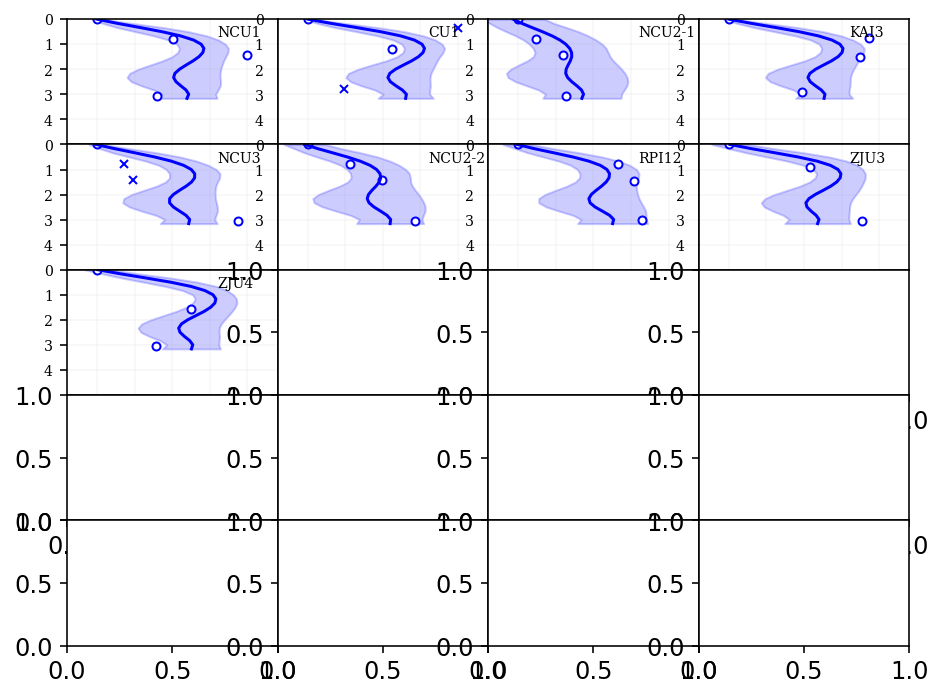

In [625]:
fig,axes = plt.subplots(nrows=5,ncols=4,figsize=(6.5,5))
fig.subplots_adjust(wspace=0,hspace=0,left=0.08, right=0.98, top=0.97, bottom=0.1)
fontdict={  'fontsize': 10, 'fontname': 'serif'}

exp_plotter('NCU1',DF,0,0)
exp_plotter('CU1',DF,0,1)
exp_plotter('NCU2-1',DF,0,2)
exp_plotter('KAI3',DF,0,3)
exp_plotter('NCU3',DF,1,0)
exp_plotter('NCU2-2',DF,1,1)
exp_plotter('RPI12',DF,1,2)
exp_plotter('ZJU3',DF,1,3)
exp_plotter('ZJU4',DF,2,0)
exp_plotter('KAI2',DF,2,1)
exp_plotter('ZJU2',DF,2,2)
exp_plotter('RPI11',DF,2,3)
exp_plotter('RPI10',DF,3,0)
exp_plotter('ZJU1',DF,3,1)
exp_plotter('UCD1',DF,3,2)
exp_plotter('RPI13',DF,3,3)
exp_plotter('KAI1',DF,4,0)
exp_plotter('RPI10',DF,4,1)
exp_plotter('RPI10',DF,4,2)
exp_plotter('RPI10',DF,4,3)
axes[4,1].set_xlabel('$r_{u}$', fontdict)
axes[4,2].set_xlabel('$r_{u}$', fontdict)
axes[2,0].set_ylabel('$Depth$ $(m)$', fontdict)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()

OutFile_Name = 'ru_Profile_1.png'
fig.savefig(OutFile_Name, dpi=300, facecolor='w', edgecolor='k',
		orientation='portrait',  format='png',)
clear_output(wait=True)


In [ ]:
# load package
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20) 
(mpl.rcParams.keys) # just a dictionary

clear_output(wait=True)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def D3_plotter():

  ax = fig.add_axes([0.05,0.1,0.95,0.9], projection='3d')
  fts=10


  mpl.rc('xtick', labelsize=12) 
  mpl.rc('ytick', labelsize=12) 
  surf = ax.plot_surface(X_plot,Y_plot,Z_mean,cmap=parula_map)

  ax.set_zlim([0,1])
  ax.set_xlabel('\n$AI^{Lat}_{1Hz}$',fontsize=fts+2, linespacing=1)
  ax.set_ylabel('\n$z (m)$',fontsize=fts+2, linespacing=1)
  ax.set_zlabel('\n$r_{u}$',fontsize=fts+2, linespacing=1)
  ax.dist = 10
  ax.xaxis._axinfo['label']['space_factor'] = 5
  #fig.subplots_adjust(wspace=0.25, hspace=0.125, left=0.115, right=0.975, top=0.9, bottom=0.17,)
  ax.text(x1[0],x1[1],x1[2],title_txt, fontsize=10,fontname='serif')
  ax.view_init(elev=30, azim=200)
#  jj=0
#  for ii in range(0,360,10):
#        jj=jj+1
#        ax.view_init(elev=35., azim=ii)
#        fig.savefig("bb%d.png" % jj)

  for tick in ax.get_xticklabels():
          tick.set_fontname("serif")
          tick.set_fontsize(fts)
  for tick in ax.get_yticklabels():
          tick.set_fontname("serif")
          tick.set_fontsize(fts)
  for tick in ax.get_zticklabels():
          tick.set_fontname("serif")
          tick.set_fontsize(fts)




In [ ]:
def compute_3D(Dr_test,X,Y):
      xy = np.column_stack((Dr_test,X[:,0],Y[:,0]))
      Z_mean, Z_var, perc, mode, samples, sampling_time  = \
      model.calc_posterior_constrained(xy, compute_mode = False, num_samples = 1000, \
      save_samples = 30, algorithm = 'minimax_tilting', resample = False)

      for i in range(1,X.shape[1]):
            print(i)
            xy = np.column_stack((Dr_test,X[:,i],Y[:,i]))
            z_mean, z_var, perc, mode, samples, sampling_time  = \
            model.calc_posterior_constrained(xy, compute_mode = False, num_samples = 1000, \
            save_samples = 30, algorithm = 'minimax_tilting', resample = False);
            
            Z_mean = np.column_stack((Z_mean,z_mean))
            Z_var = np.column_stack((Z_var,z_var))
      
      return Z_mean,Z_var

In [ ]:
def compute_3D_AI_fixed(X,Dr_test,Y):
      xy = np.column_stack((X[:,0],AI_test,Y[:,0]))
      Z_mean, Z_var, perc, mode, samples, sampling_time  = \
      model.calc_posterior_constrained(xy, compute_mode = False, num_samples = 1000, \
      save_samples = 30, algorithm = 'minimax_tilting', resample = False)

      for i in range(1,X.shape[1]):
            print(i)
            xy = np.column_stack((X[:,i],AI_test,Y[:,i]))
            z_mean, z_var, perc, mode, samples, sampling_time  = \
            model.calc_posterior_constrained(xy, compute_mode = False, num_samples = 1000, \
            save_samples = 30, algorithm = 'minimax_tilting', resample = False);
            
            Z_mean = np.column_stack((Z_mean,z_mean))
            Z_var = np.column_stack((Z_var,z_var))
      
      return Z_mean,Z_var

In [ ]:
AI_plot = np.linspace(AImin_norm, AImax_norm, n_plot)
X, Y = np.meshgrid(AI_plot, H_plot)
Dr_test = ((71-Qcrmin)/(Qcrmax-Qcrmin))*(np.ones((n_plot,1)))
title_txt = 'Dr = 55%'
x1=(1.8,0.8,1.2)

(Z_mean,Z_var) = compute_3D(Dr_test,X,Y)

X_plot = (X*(AImax-AImin)) + AImin
Y_plot = (Y*(Hmax-Hmin)) + Hmin
fig = plt.figure(figsize=(6,3.5))
D3_plotter()
 
OutFile_Name = '3D_Dr_55.png'
fig.savefig(OutFile_Name, dpi=300, facecolor='w', edgecolor='k',
		orientation='portrait',  format='png',)
clear_output(wait=True)

In [ ]:
AI_plot = np.linspace(AImin_norm, AImax_norm, n_plot)
X, Y = np.meshgrid(AI_plot, H_plot)
Dr_test = ((112-Qcrmin)/(Qcrmax-Qcrmin))*(np.ones((n_plot,1)))
title_txt = 'Dr = 65%'
x1=(1.8,0.8,1.2)

(Z_mean,Z_var) = compute_3D(Dr_test,X,Y)

X_plot = (X*(AImax-AImin)) + AImin
Y_plot = (Y*(Hmax-Hmin)) + Hmin
fig = plt.figure(figsize=(6,3.5))
D3_plotter()
 
OutFile_Name = '3D_Dr_65.png'
fig.savefig(OutFile_Name, dpi=300, facecolor='w', edgecolor='k',
		orientation='portrait',  format='png',)
clear_output(wait=True)

In [ ]:
AI_plot = np.linspace(AImin_norm, AImax_norm, n_plot)
X, Y = np.meshgrid(AI_plot, H_plot)
Dr_test = ((161-Qcrmin)/(Qcrmax-Qcrmin))*(np.ones((n_plot,1)))
title_txt = 'Dr = 75%'
x1=(1.8,0.8,1.2)

(Z_mean,Z_var) = compute_3D(Dr_test,X,Y)

X_plot = (X*(AImax-AImin)) + AImin
Y_plot = (Y*(Hmax-Hmin)) + Hmin
fig = plt.figure(figsize=(6,3.5))
D3_plotter()
 
OutFile_Name = '3D_Dr_75.png'
fig.savefig(OutFile_Name, dpi=300, facecolor='w', edgecolor='k',
		orientation='portrait',  format='png',)
clear_output(wait=True)


In [ ]:
AI_plot = np.linspace(AImin_norm, AImax_norm, n_plot)
X, Y = np.meshgrid(Qcr_plot, H_plot)
AI_test = ((1.6-AImin)/(AImax-AImin))*(np.ones((n_plot,1)))
title_txt = 'AI = 1.6'
x1=(60,0.8,1.2)

(Z_mean,Z_var) = compute_3D_AI_fixed(X,Dr_test,Y)

X_plot = (X*(Qcrmax-Qcrmin)) + Qcrmin
X_plot=-0.0003677*(X_plot**2)+0.3078*X_plot+35.01;
Y_plot = (Y*(Hmax-Hmin)) + Hmin
fig = plt.figure(figsize=(6,3.5))
D3_plotter()
 
OutFile_Name = '3D_Dr_75.png'
fig.savefig(OutFile_Name, dpi=300, facecolor='w', edgecolor='k',
		orientation='portrait',  format='png',)
clear_output(wait=True)

In [ ]:
AI_plot = np.linspace(AImin_norm, AImax_norm, n_plot)
X, Y = np.meshgrid(Qcr_plot, H_plot)
AI_test = ((1-AImin)/(AImax-AImin))*(np.ones((n_plot,1)))
title_txt = 'AI = 1.0'
x1=(60,0.8,1.2)

(Z_mean,Z_var) = compute_3D_AI_fixed(X,Dr_test,Y)

X_plot = (X*(Qcrmax-Qcrmin)) + Qcrmin
X_plot=-0.0003677*(X_plot**2)+0.3078*X_plot+35.01;
Y_plot = (Y*(Hmax-Hmin)) + Hmin
fig = plt.figure(figsize=(6,3.5))
D3_plotter()
 
OutFile_Name = '3D_Dr_75.png'
fig.savefig(OutFile_Name, dpi=300, facecolor='w', edgecolor='k',
		orientation='portrait',  format='png',)
clear_output(wait=True)


In [ ]:
AI_plot = np.linspace(AImin_norm, AImax_norm, n_plot)
X, Y = np.meshgrid(Qcr_plot, H_plot)
AI_test = ((0.6-AImin)/(AImax-AImin))*(np.ones((n_plot,1)))
title_txt = 'AI = 0.6'
x1=(60,0.8,1.2)

(Z_mean,Z_var) = compute_3D_AI_fixed(X,Dr_test,Y)

X_plot = (X*(Qcrmax-Qcrmin)) + Qcrmin
X_plot=-0.0003677*(X_plot**2)+0.3078*X_plot+35.01;
Y_plot = (Y*(Hmax-Hmin)) + Hmin
fig = plt.figure(figsize=(6,3.5))
D3_plotter()
 
OutFile_Name = '3D_Dr_75.png'
fig.savefig(OutFile_Name, dpi=300, facecolor='w', edgecolor='k',
		orientation='portrait',  format='png',)
clear_output(wait=True)

In [ ]:
def curves_2D(Dr_vec,AI_vec,leg,txt,nr):
  H = H_plot*(Hmax-Hmin)+Hmin
  c = 0
  for i in range(0,len(AI_vec),1):
    for j in range(0,len(Dr_vec),1):
        # AI equal to 1.6
        Dr_test = ((Dr_vec[j]-Qcrmin)/(Qcrmax-Qcrmin))*(np.ones((n_plot,1)))
        AI_test = ((AI_vec[i]-AImin)/(AImax-AImin))*(np.ones((n_plot,1)))
        xy = np.column_stack((Dr_test,AI_test,H_plot))

        Z_mean, Z_var, perc, mode, samples, sampling_time  = \
        model.calc_posterior_constrained(xy, compute_mode = False, num_samples = 1000, \
        save_samples = 1, algorithm = 'minimax_tilting', resample = False)
        axes[nr].plot(Z_mean,H,color=colors[c],linewidth=1.5,label=(r'$AI^{Lat}_{1Hz}$ = '+ str(leg[c])))
        c = c + 1 
        clear_output(wait=True)
        axes[nr].set_ylim(4.99999, 0)
        axes[nr].set_xlim(-0.199999, 1.199999)
        axes[nr].text(0.8,0.7,(r'$D_r$ = '+ txt),fontdict={  'fontsize': 10, 'fontname': 'serif'})
        axes[nr].set_xticks(np.arange(0, 1.25, 0.25))
        axes[nr].set_yticks(np.arange(0.0001, 5, 1)) 
        axes[nr].grid(alpha=0.1)
        for tick in axes[nr].get_xticklabels():
            tick.set_fontname("serif")
            tick.set_fontsize(9)
        for tick in axes[nr].get_yticklabels():
            tick.set_fontname("serif")
            tick.set_fontsize(9)

In [ ]:
colors=['magenta','red','blue','green','brown']
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(3,5))
fig.subplots_adjust(wspace=0,hspace=0,left=0.15, right=0.9, top=0.97, bottom=0.1)
fontdict={  'fontsize': 10, 'fontname': 'serif'}

Dr_vec=[71]
AI_vec=[1.6,1.4,1,0.6,0.3]
curves_2D(Dr_vec,AI_vec,AI_vec,'55%',0)

Dr_vec=[112]
AI_vec=[1.6,1.4,1,0.6,0.3]
curves_2D(Dr_vec,AI_vec,AI_vec,'65%',1)

Dr_vec=[161]
AI_vec=[1.6,1.4,1,0.6,0.3]
curves_2D(Dr_vec,AI_vec,AI_vec,'75%',2)
axes[2].legend(loc=4,prop={'size': 8})

axes[2].set_xlabel('$r_{u}$', fontdict)
axes[1].set_ylabel('$Depth$ $(m)$', fontdict)

OutFile_Name = '2D_fixed_Dr.png'
fig.savefig(OutFile_Name, dpi=300, facecolor='w', edgecolor='k',
		orientation='portrait',  format='png',)
clear_output(wait=True)

# PREDICTIONS FOR TEST WITHOUT CPT

In [39]:
import pandas as pd
import numpy as np
from IPython.display import clear_output

df_d = pd.read_excel('WALL_TABLE_PYTHON_NO_CPT.xlsx') 
df_d.head()

y = df_d[['ru_end']]
X = df_d[['Qcr', 'AI','H']]
m = len(y)
n = np.size(X,1)
y = np.hstack((np.ones((m,1)),y))
X = np.hstack((np.ones((m,1)),X))
X = np.delete(X,[0],axis=1)
y = np.delete(y,[0],axis=1)
y = y.flatten()


Qcrmax = np.max(X[:,0])
Qcrmin = np.min(X[:,0])
X[:,0] = (X[:,0]-Qcrmin)/(Qcrmax-Qcrmin)
AImax = np.max(X[:,1])
AImin = np.min(X[:,1])
X[:,1] = (X[:,1]-AImin)/(AImax-AImin)
Hmax = np.max(X[:,2])
Hmin = np.min(X[:,2])
X[:,2] = (X[:,2]-Hmin)/(Hmax-Hmin)

Qcrmax_norm = np.max(X[:,0])
Qcrmin_norm = np.min(X[:,0])


AImax_norm = np.max(X[:,1])
AImin_norm = np.min(X[:,1])

Hmax_norm = np.max(X[:,2])
Hmin_norm = np.min(X[:,2])
n_plot = 20
Qcr_plot = np.linspace(Qcrmin_norm, Qcrmax_norm, n_plot)
AI_plot = np.linspace(AImin_norm, AImax_norm, n_plot)
H_plot = np.linspace(Hmin_norm, Hmax_norm, n_plot)

X_train = X
y_train = y

Text(43.54166666666666, 0.5, '$Depth$ $(m)$')

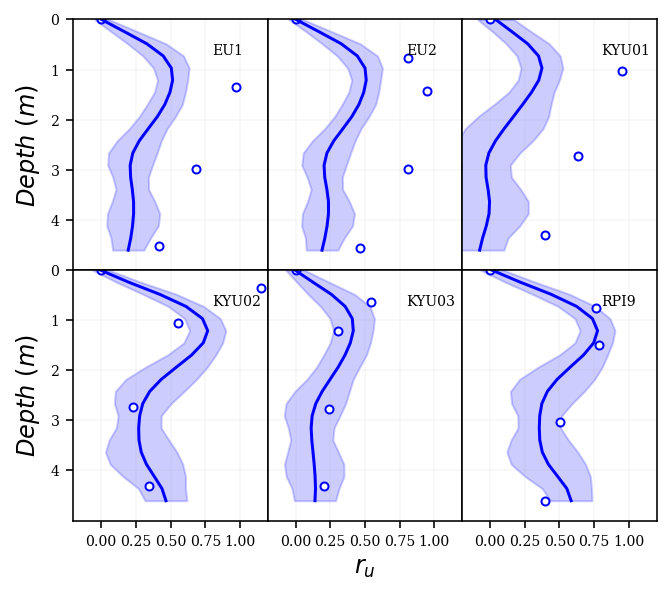

In [40]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(4.5,4))
fig.subplots_adjust(wspace=0,hspace=0,left=0.08, right=0.98, top=0.97, bottom=0.1)
fontdict={  'fontsize': 12, 'fontname': 'serif'}

df1 = (df_d['Qcr']-Qcrmin)/(Qcrmax-Qcrmin)
df2 = (df_d['AI']-AImin)/(AImax-AImin)
df3 = (df_d['H']-Hmin)/(Hmax-Hmin)
df4 = df_d['ru_end']
df0 = df_d['Label']
DF = pd.concat([df0,df1,df2,df3,df4], axis=1, join='inner')
DF['marker'] = DF['ru_end']
for i in range(0,DF.shape[0],1):
      DF['marker'][i] = 'o'

exp_plotter('EU1',DF,0,0)
exp_plotter('EU2',DF,0,1)
exp_plotter('KYU01',DF,0,2)
exp_plotter('KYU02',DF,1,0)
exp_plotter('KYU03',DF,1,1)
exp_plotter('RPI9',DF,1,2)
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axes.flat:
    ax.label_outer()

OutFile_Name = 'ru_Profile_no_cpt.png'
fig.savefig(OutFile_Name, dpi=300, facecolor='w', edgecolor='k',
		orientation='portrait',  format='png',)
clear_output(wait=True)

axes[1,1].set_xlabel('$r_{u}$', fontdict)
axes[1,0].set_ylabel('$Depth$ $(m)$', fontdict)
axes[0,0].set_ylabel('$Depth$ $(m)$', fontdict)

In [41]:
Z_mean, Z_var, perc, mode, samples, sampling_time  = \
model.calc_posterior_constrained(X_train, compute_mode = False, num_samples = 1000, \
save_samples = 1, algorithm = 'minimax_tilting', resample = False)
r2 = r2_score(y_train, Z_mean)
clear_output(wait=True)

print('R2 for experiments with no CPT is equal to ',r2)



R2 for experiments with no CPT is equal to  0.03966785293659025
